**Project Done by - Amit kumar** <br>
**Email - amitkashyapm7050@gmail.com** <br>
**Institute roll - 22MI10012** <br>
**Institute name - IIT Kharagpur.**

# Detecting Spam Emails Using Tensorflow in Python

Spam messages are unsolicited or unwanted messages/emails sent in bulk to users. Most messaging/emailing services automatically detect these messages as spam to prevent inboxes from being flooded. These messages are typically promotional and unusual. Therefore, we can create machine learning/deep learning models to detect spam messages. We will create a spam detector using TensorFlow; we need to classify the texts as 'Spam' or 'Ham.' This means that spam detection is a text classification problem. Therefore, we will conduct exploratory data analysis on our dataset and build a text classification model.

 Importing necessary libraries for EDA

In [9]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importing libraries necessary for Model Building and Training

In [10]:
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [12]:

data = pd.read_csv('emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [13]:
data.shape

(5728, 2)

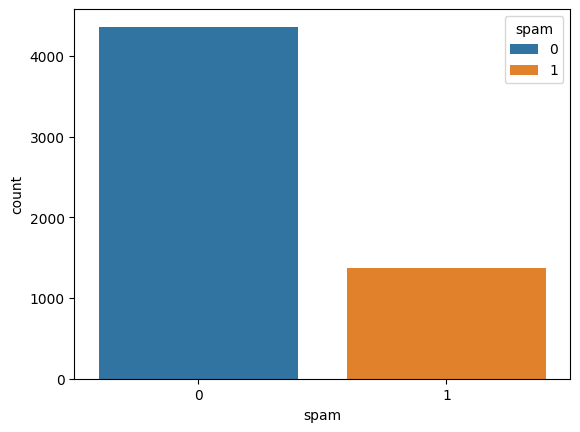

In [14]:
sns.countplot(x='spam' , data=data , hue='spam')
plt.show()

We can clearly see that number of samples of Ham is much more than that of Spam which implies that the dataset we are using is imbalanced. 

 Downsampling to balance the dataset

Text(0.5, 0, 'Message types')

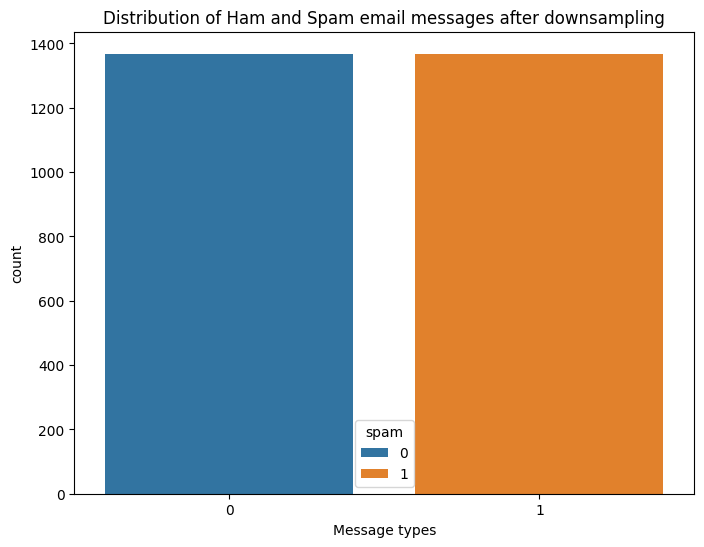

In [15]:
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)

balanced_data = pd.concat([ham_msg,spam_msg],axis=0)

plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam' , hue='spam')

plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

# Text Preprocessing
Textual data is highly unstructured and needs attention in many aspects:
1.Stopwords Removal
2.Punctuations Removal
3.Stemming or Lemmatization

In [16]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject' , '')
balanced_data.head()

,text,spam
1547,: interview schedule for jinbaek kim i didn '...,0
2730,": re : wednesday meeting eric , i think we c...",0
4843,: re : london research group i ' d do it as s...,0
2856,": re : congratulations vince , thanks for you...",0
3804,: osman sezgen steve kromer is requesting tha...,0


In [17]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
1547,interview schedule for jinbaek kim i didn t...,0
2730,re wednesday meeting eric i think we can ...,0
4843,re london research group i d do it as soon...,0
2856,re congratulations vince thanks for your n...,0
3804,osman sezgen steve kromer is requesting that...,0


below function is a helper function that will help us to remove the stop words.

In [18]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
1547,interview schedule jinbaek kim see went happy ...,0
2730,wednesday meeting eric think skip meeting disc...,0
4843,london research group soon possible call exact...,0
2856,congratulations vince thanks note congratulati...,0
3804,osman sezgen steve kromer requesting osman spe...,0


A word cloud is a text visualization tool that help’s us to get insights into the most frequent words present in the corpus of the data.

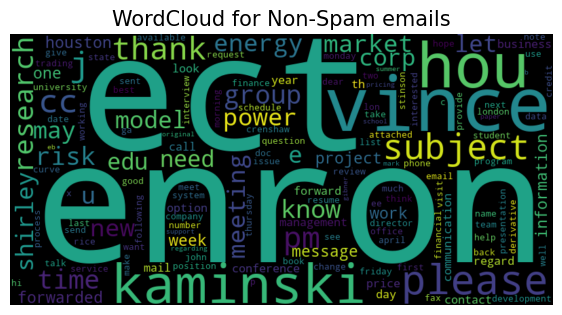

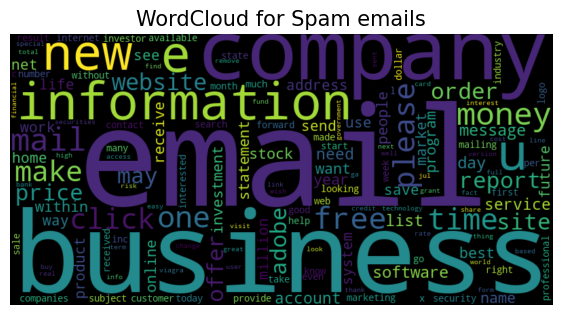

In [19]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=150,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [20]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)

# Word2Vec Conversion

In order to effectively train our machine learning model, we must first convert our text data into numerical vectors through a process of assigning token IDs to each word and padding the resulting vectors. By applying this approach, we can optimize the model's ability to process and interpret the data. The tokenizer has already been set up with our training data, and will be instrumental in processing both the training and validation data into numerical vectors.

In [21]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

# Build the model

We will implement a Sequential model which will contain the following parts:

Three Embedding Layers to learn featured vector representations of the input vectors.

An LSTM layer to identify useful patterns in the sequence.

Then we will have one fully connected layer

The final layer is the output layer which outputs probabilities for the two classes.

In [22]:

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808737 (3.09 MB)
Trainable params: 808737 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


While compiling a model we provide these three essential parameters:



optimizer – This is the method that helps to optimize the cost function by using gradient descent.


loss – The loss function by which we monitor whether the model is improving with training or not.


metrics – This helps to evaluate the model by predicting the training and the validation data.

In [23]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

Even if the model's performance is not improving, EarlyStopping will stop training. We can also define custom callbacks to stop training if the desired results are obtained early.

In [24]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

### Train the model

In [25]:

history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20


69/69 [==============================] - 10s 67ms/step - loss: 0.6047 - accuracy: 0.7093 - val_loss: 0.2397 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 3s 50ms/step - loss: 0.1231 - accuracy: 0.9776 - val_loss: 0.1458 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 4s 62ms/step - loss: 0.0691 - accuracy: 0.9872 - val_loss: 0.1605 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 4s 62ms/step - loss: 0.0534 - accuracy: 0.9909 - val_loss: 0.1804 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 5s 71ms/step - loss: 0.0453 - accuracy: 0.9922 - val_loss: 0.1970 - val_accuracy: 0.9599 - lr: 5.0000e-04


In [26]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 [==============================] - 0s 10ms/step - loss: 0.1458 - accuracy: 0.9672
Test Loss : 0.1457786113023758
Test Accuracy : 0.9671533107757568


**The training accuracy is an impressive 98.17%, demonstrating the effectiveness of the training process.**

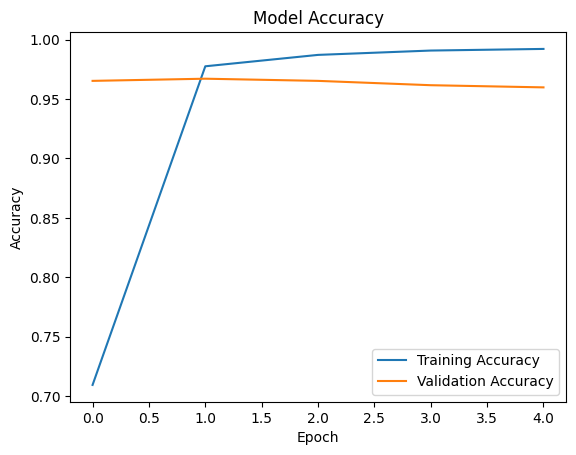

In [27]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred = model.predict(test_sequences)
y_pred = np.round(y_pred)
f1 = f1_score(test_Y, y_pred)
precision = precision_score(test_Y, y_pred)
recall = recall_score(test_Y, y_pred)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


18/18 [==============================] - 1s 9ms/step
F1 Score: 0.9680851063829787
Precision: 0.9680851063829787
Recall: 0.9680851063829787


18/18 [==============================] - 0s 9ms/step


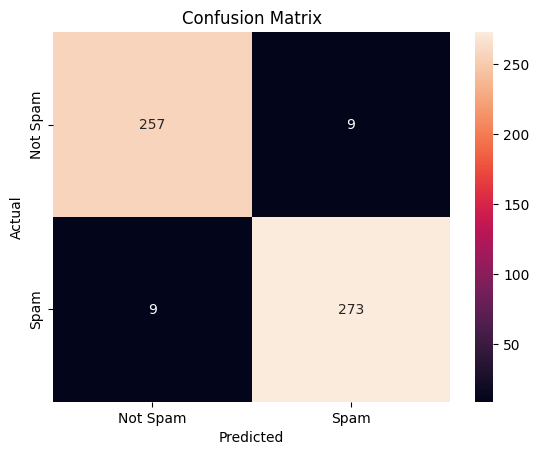

In [29]:
from sklearn.metrics import confusion_matrix


y_pred = model.predict(test_sequences)
y_pred = np.round(y_pred)

cm = confusion_matrix(test_Y, y_pred)

labels = ['Not Spam', 'Spam']

sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Conculsion
*  training accuracy is 98.17%, demonstrating the effectiveness of the training process
*  F1 Score: 96.80%
*  Precision: 96.80%
*  Recall: 96.80%

  787

**references** <br>
* GeekForGeek machine learning tutorial https://www.geeksforgeeks.org/
* Kaggle spam email dataset.
* Krish Naik, codebasic machine learning YouTube video.
* Gemini ai and chat GPT.  